# Sorting Benchmark Analysis

This notebook analyzes the CSV results from our batch tests comparing several sorting methods:

- **Bitonic Sort:** `bitonic` (sequential) and `bitonic_parallel` (parallel)
- **Merge Sort:** `mergesort` (sequential) and `mergesort_parallel` (parallel)

We will examine:

- How the runtime scales with input size.
- The impact of varying the number of OpenMP threads and task thresholds on the parallel methods.
- A comparison of sequential versus parallel runtimes.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Ensure plots appear in the notebook.
%matplotlib inline

# Load the CSV file; update the file name if needed.
df = pd.read_csv("../report/batchs/hype_complete.csv")

# Display first few rows for an initial look.
df.head()

max_threads = df["omp_num_threads"].max()
default_threshold = 1024
default_input_size = 16777216


In [2]:
# Data Preprocessing
# Convert N to integer (if necessary, strip non-numeric parts if your reported N is a string)
def extract_N(x):
    try:
        return int(x)
    except ValueError:
        # Remove any stray characters (like .in extension) and convert.
        return int("".join(filter(str.isdigit, x)))
    
df["N"] = df["N"].apply(extract_N)
df["task_threshold"] = df["task_threshold"].astype(int)
df["omp_num_threads"] = df["omp_num_threads"].astype(int)
df["mean_time"] = df["mean_time"].astype(float)
df["std_deviation"] = df["std_deviation"].astype(float)

# For later plotting, let’s also extract the numeric input size from the input file name.
def get_input_size(fname):
    # Assume the filename is like "in_<number>.in"
    num = "".join(filter(str.isdigit, fname))
    return int(num) if num else None

df["input_size"] = df["input_file"].apply(get_input_size)

# Check the types.
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 950 entries, 0 to 949
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   sort_method       950 non-null    object 
 1   input_file        950 non-null    object 
 2   N                 950 non-null    int64  
 3   task_threshold    950 non-null    int64  
 4   omp_num_threads   950 non-null    int64  
 5   repetitions       950 non-null    int64  
 6   mean_time         950 non-null    float64
 7   std_deviation     950 non-null    float64
 8   individual_times  950 non-null    object 
 9   input_size        950 non-null    int64  
dtypes: float64(2), int64(5), object(3)
memory usage: 74.3+ KB


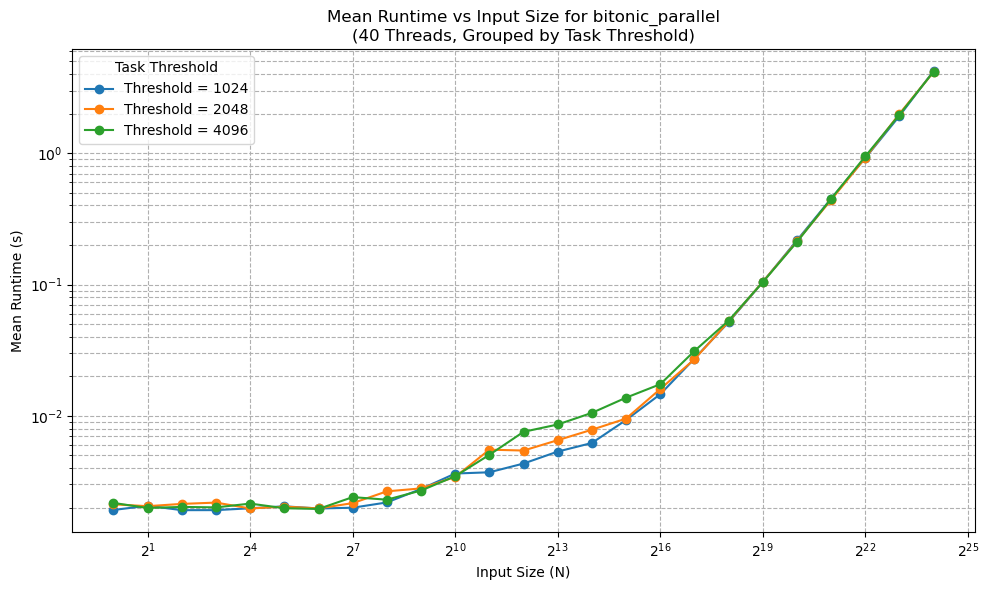

In [3]:
bitonic_parallel_df = df[(df["sort_method"] == "bitonic_parallel") & (df["omp_num_threads"] == max_threads)]

# Retrieve the unique threshold values.
threshold_values = sorted(bitonic_parallel_df["task_threshold"].unique())

plt.figure(figsize=(10, 6))

for thr in threshold_values:
    subset = bitonic_parallel_df[bitonic_parallel_df["task_threshold"] == thr]
    subset = subset.sort_values("input_size")
    plt.plot(subset["input_size"], subset["mean_time"],
             marker="o", linestyle="-", label=f"Threshold = {thr}")

plt.xlabel("Input Size (N)")
plt.ylabel("Mean Runtime (s)")
plt.title(f"Mean Runtime vs Input Size for bitonic_parallel\n({max_threads} Threads, Grouped by Task Threshold)")


plt.xscale("log", base=2)
plt.yscale("log")
plt.legend(title="Task Threshold")
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()


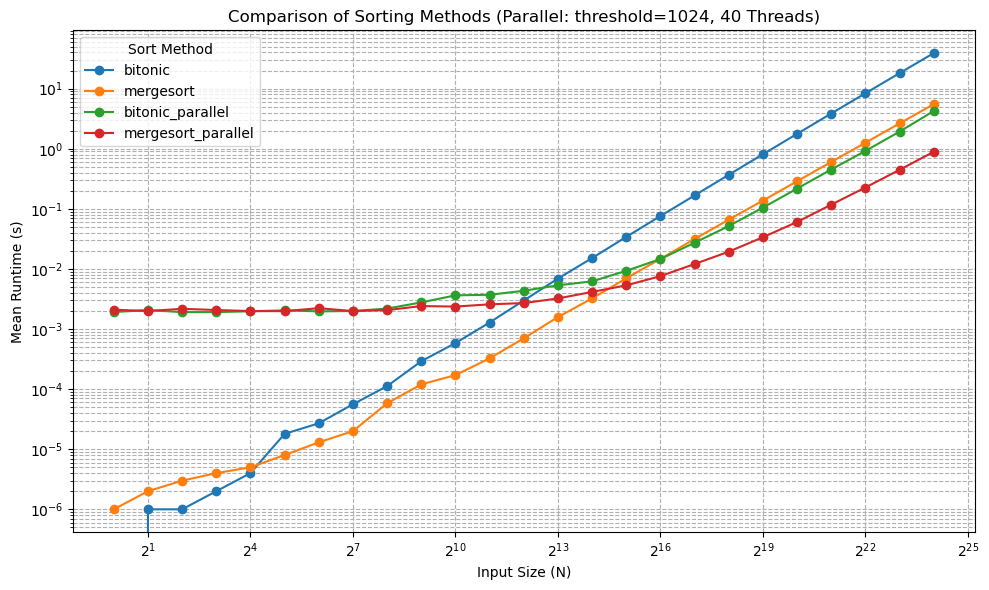

In [4]:
# %% [code]
import matplotlib.pyplot as plt

# Determine the maximum number of threads used for parallel runs.
parallel_df = df[df["sort_method"].isin(["bitonic_parallel", "mergesort_parallel"])]

# Filter for sequential sorts.
seq_df = df[df["sort_method"].isin(["bitonic", "mergesort"])]

# For parallel sorts, we keep only those runs with threshold = 1024 and the max number of threads.
par_df = df[
    (df["sort_method"].isin(["bitonic_parallel", "mergesort_parallel"])) &
    (df["task_threshold"] == default_threshold) &
    (df["omp_num_threads"] == max_threads)
]

plt.figure(figsize=(10, 6))

# List of all methods we want to compare.
methods = ["bitonic", "mergesort", "bitonic_parallel", "mergesort_parallel"]

for method in methods:
    if method in ["bitonic", "mergesort"]:
        subset = seq_df[seq_df["sort_method"] == method]
    else:
        subset = par_df[par_df["sort_method"] == method]
    subset = subset.sort_values("input_size")
    plt.plot(subset["input_size"], subset["mean_time"],
             marker="o", linestyle="-", label=method)

plt.xlabel("Input Size (N)")
plt.ylabel("Mean Runtime (s)")
plt.title(f"Comparison of Sorting Methods (Parallel: threshold={default_threshold}, {max_threads} Threads)")
plt.xscale("log", base=2)
plt.yscale("log")
plt.grid(True, which="both", ls="--")
plt.legend(title="Sort Method")
plt.tight_layout()
plt.show()


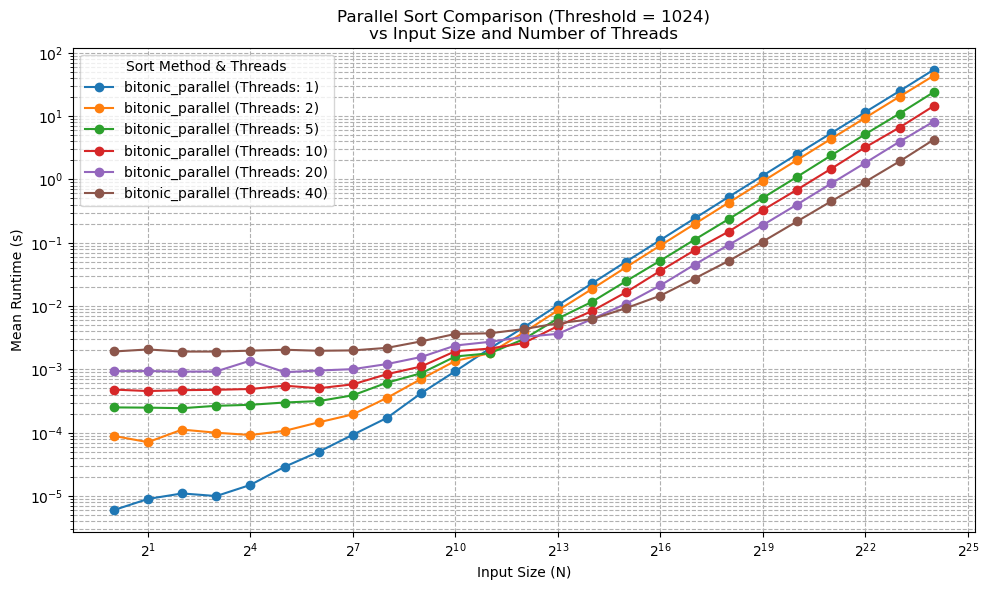

In [5]:
# Filter the DataFrame for parallel sorts with a fixed threshold of 1024.
df_filtered = df[
    (df["task_threshold"] == default_threshold) &
    (df["sort_method"].isin(["bitonic_parallel"]))
]

# Retrieve unique thread counts and sort methods.
threads = sorted(df_filtered["omp_num_threads"].unique())
sorts = sorted(df_filtered["sort_method"].unique())

plt.figure(figsize=(10, 6))

# For each sort method and each thread count, plot mean runtime vs input size.
for s in sorts:
    for t in threads:
        sub = df_filtered[(df_filtered["sort_method"] == s) & (df_filtered["omp_num_threads"] == t)]
        if sub.empty:
            continue
        sub_sorted = sub.sort_values("input_size")
        label = f"{s} (Threads: {t})"
        plt.plot(sub_sorted["input_size"], sub_sorted["mean_time"],
                 marker="o", linestyle="-", label=label)

plt.xlabel("Input Size (N)")
plt.ylabel("Mean Runtime (s)")
plt.title(f"Parallel Sort Comparison (Threshold = {default_threshold})\nvs Input Size and Number of Threads")
plt.xscale("log", base=2)
plt.yscale("log")
plt.legend(title="Sort Method & Threads", loc="best")
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()


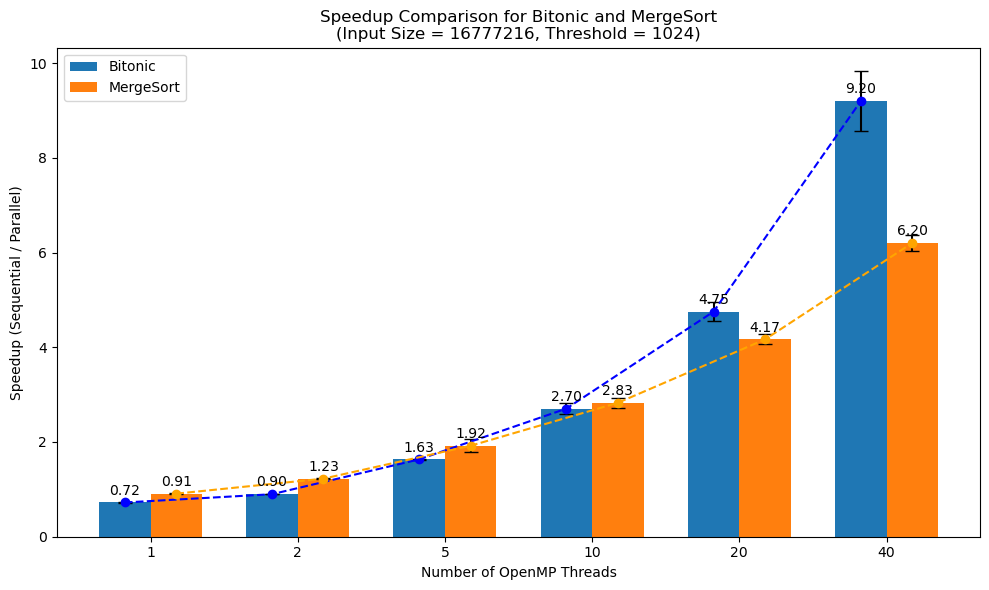

In [6]:
# Retrieve the sequential baseline for bitonic and mergesort at the chosen input size.
bitonic_seq = df[(df["sort_method"] == "bitonic") & (df["input_size"] == default_input_size)]
mergesort_seq = df[(df["sort_method"] == "mergesort") & (df["input_size"] == default_input_size)]

if bitonic_seq.empty or mergesort_seq.empty:
    print("Sequential baseline data not found for the chosen input size.")
else:
    bitonic_seq_time = bitonic_seq["mean_time"].iloc[0]
    bitonic_seq_std = bitonic_seq["std_deviation"].iloc[0]
    mergesort_seq_time = mergesort_seq["mean_time"].iloc[0]
    mergesort_seq_std = mergesort_seq["std_deviation"].iloc[0]
    
    # For parallel runs, filter for threshold == 1024.
    parallel_methods = ["bitonic_parallel", "mergesort_parallel"]
    par_df = df[(df["sort_method"].isin(parallel_methods)) &
                (df["task_threshold"] == default_threshold) &
                (df["input_size"] == default_input_size)]
    
    # Get the available thread counts from the parallel data.
    thread_counts = sorted(par_df["omp_num_threads"].unique())
    
    bitonic_speedup = []
    bitonic_speedup_err = []
    mergesort_speedup = []
    mergesort_speedup_err = []
    
    for thr in thread_counts:
        # Get the parallel result for bitonic_parallel for the given thread count.
        bp = df[(df["sort_method"] == "bitonic_parallel") &
                (df["input_size"] == default_input_size) &
                (df["task_threshold"] == default_threshold) &
                (df["omp_num_threads"] == thr)]
        if not bp.empty:
            bp_time = bp["mean_time"].iloc[0]
            bp_std = bp["std_deviation"].iloc[0]
            speedup_bp = bitonic_seq_time / bp_time
            # Error propagation (approximate)
            error_bp = speedup_bp * np.sqrt((bitonic_seq_std / bitonic_seq_time)**2 + (bp_std / bp_time)**2)
        else:
            speedup_bp = np.nan
            error_bp = np.nan
        
        # Get the parallel result for mergesort_parallel.
        mp = df[(df["sort_method"] == "mergesort_parallel") &
                (df["input_size"] == default_input_size) &
                (df["task_threshold"] == default_threshold) &
                (df["omp_num_threads"] == thr)]
        if not mp.empty:
            mp_time = mp["mean_time"].iloc[0]
            mp_std = mp["std_deviation"].iloc[0]
            speedup_mp = mergesort_seq_time / mp_time
            error_mp = speedup_mp * np.sqrt((mergesort_seq_std / mergesort_seq_time)**2 + (mp_std / mp_time)**2)
        else:
            speedup_mp = np.nan
            error_mp = np.nan
        
        bitonic_speedup.append(speedup_bp)
        bitonic_speedup_err.append(error_bp)
        mergesort_speedup.append(speedup_mp)
        mergesort_speedup_err.append(error_mp)
    
    # Create the bar chart.
    x = np.arange(len(thread_counts))  # one position per thread count
    width = 0.35  # width of each bar
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot bars for bitonic speedup.
    rects1 = ax.bar(x - width/2, bitonic_speedup, width,
                    yerr=bitonic_speedup_err, capsize=5, label="Bitonic")
    # Plot bars for mergesort speedup.
    rects2 = ax.bar(x + width/2, mergesort_speedup, width,
                    yerr=mergesort_speedup_err, capsize=5, label="MergeSort")
    
    # Add tendency lines (dashed lines) connecting the bars.
    ax.plot(x - width/2, bitonic_speedup, marker="o", linestyle="--", color="blue")
    ax.plot(x + width/2, mergesort_speedup, marker="o", linestyle="--", color="orange")

    # Annotate speedup values on the bars.
    for i, (speedup_bp, speedup_mp) in enumerate(zip(bitonic_speedup, mergesort_speedup)):
        if not np.isnan(speedup_bp):
            ax.text(x[i] - width/2, speedup_bp + 0.1, f"{speedup_bp:.2f}", ha="center", va="bottom", fontsize=10)
        if not np.isnan(speedup_mp):
            ax.text(x[i] + width/2, speedup_mp + 0.1, f"{speedup_mp:.2f}", ha="center", va="bottom", fontsize=10)
    
    ax.set_xlabel("Number of OpenMP Threads")
    ax.set_ylabel("Speedup (Sequential / Parallel)")
    ax.set_title(f"Speedup Comparison for Bitonic and MergeSort\n(Input Size = {default_input_size}, Threshold = {default_threshold})")
    ax.set_xticks(x)
    ax.set_xticklabels(thread_counts)
    ax.legend()
    
    plt.tight_layout()
    plt.show()


# Conclusions and Discussion

- **Scaling with Input Size:**  
  The log-log chart shows how the mean runtime increases with input size for each algorithm. Notice the different slopes indicating asymptotic behavior.

- **Parallel Scalability:**  
  For both `bitonic_parallel` and `mergesort_parallel`, the runtime decreases as the number of threads increases (Chart 2). However, the scalability might level off depending on the input size and overhead of task management.

- **Task Threshold Impact:**  
  Chart 3 shows that the task threshold can significantly affect the parallel runtime. Tuning this parameter is important for achieving optimal performance.

- **Sequential vs. Parallel:**  
  Chart 4 compares the sequential and parallel runtimes for a large input size. The computed speedup demonstrates the benefits (or limitations) of parallelization for each algorithm.

These charts provide insights into how well each method parallelizes the problem and the interplay between input size, threshold, and thread count. Feel free to modify the filters or add further analysis as needed.
